In [5]:
import numpy as np
import matplotlib.pylab as plt
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

In [2]:
def exponential_cov(x, y, params):
    return params[0] * np.exp( -0.5 * params[1] * np.subtract.outer(x, y)**2)

In [3]:
def conditional(x_new, x, y, params):
    B = exponential_cov(x_new, x, params)
    C = exponential_cov(x, x, params)
    A = exponential_cov(x_new, x_new, params)

    mu = np.linalg.inv(C).dot(B.T).T.dot(y)
    sigma = A - B.dot(np.linalg.inv(C).dot(B.T))

    return(mu.squeeze(), sigma.squeeze())

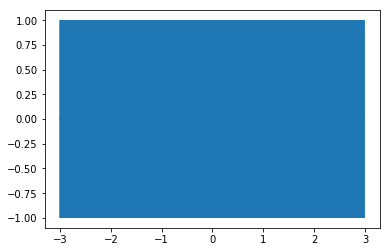

In [7]:
θ = [1, 10]
σ_0 = exponential_cov(0, 0, θ)
xpts = np.arange(-3, 3, step=0.01)
plt.errorbar(xpts, np.zeros(len(xpts)), yerr=σ_0, capsize=0)
plt.show()

In [8]:
x = [1.]
y = [np.random.normal(scale=σ_0)]
y

[0.7742667168515752]

In [9]:
σ_1 = exponential_cov(x, x, θ)
 
def predict(x, data, kernel, params, sigma, t):
    k = [kernel(x, y, params) for y in data]
    Sinv = np.linalg.inv(sigma)
    y_pred = np.dot(k, Sinv).dot(t)
    sigma_new = kernel(x, x, params) - np.dot(k, Sinv).dot(k)
    return y_pred, sigma_new
 
x_pred = np.linspace(-3, 3, 1000)
predictions = [predict(i, x, exponential_cov, θ, σ_1, y) for i in x_pred]

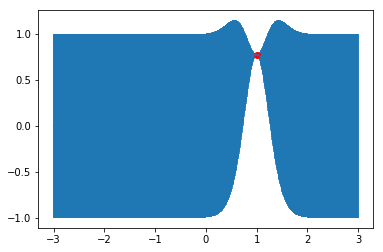

In [10]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")
plt.show()

In [11]:
m, s = conditional([-0.7], x, y, θ)
y2 = np.random.normal(m, s)
y2

-0.20867436607640844

In [12]:
x.append(-0.7)
y.append(y2)
 
σ_2 = exponential_cov(x, x, θ)
predictions = [predict(i, x, exponential_cov, θ, σ_2, y) for i in x_pred]

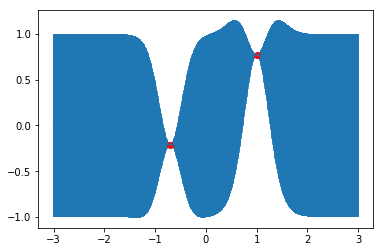

In [13]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")
plt.show()

In [14]:
x_more = [-2.1, -1.5, 0.3, 1.8, 2.5]
mu, s = conditional(x_more, x, y, θ)
y_more = np.random.multivariate_normal(mu, s)
y_more

array([ 0.70674318,  0.63597166,  0.42837972, -0.00310482, -1.07248975])

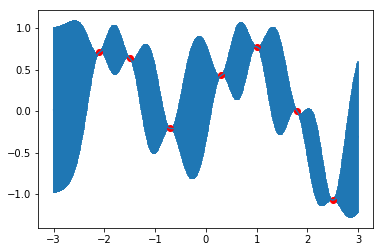

In [15]:
x += x_more
y += y_more.tolist()
 
σ_new = exponential_cov(x, x, θ)
predictions = [predict(i, x, exponential_cov, θ, σ_new, y) for i in x_pred]
 
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")
plt.show()

In [16]:
kernel = ConstantKernel() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1)

In [17]:
X = np.asarray(x).reshape(-1, 1)
X.shape

(7, 1)

In [18]:
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(X, y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 + Matern(length_scale=2, nu=1.5) + WhiteKernel(noise_level=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [19]:
gp.kernel_

0.00316**2 + Matern(length_scale=1.41, nu=1.5) + WhiteKernel(noise_level=1e-05)

In [20]:
x_pred = np.linspace(-6, 6).reshape(-1,1)
y_pred, sigma = gp.predict(x_pred, return_std=True)

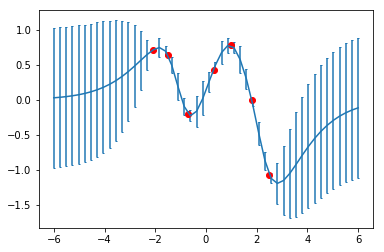

In [27]:
# y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigma, capsize=1)
plt.plot(x, y, "ro")
plt.show()